In [1]:
import pandas as pd

from eoles.utils import get_config, process_heating_need, create_hourly_residential_demand_profile, heating_hourly_profile, get_pandas, load_evolution_data
from eoles.process_cost_efficiency import piecewise_linearization_cost_efficiency
from eoles.model_heat_coupling import ModelEOLES
import logging

from project.model import get_inputs, social_planner  # imports from ResIRF package
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# set seaborn style
sns.set_theme()

# Preprocessing

In [2]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

In [5]:
L = [1850,1750,1800,1850,1900,1950,2050,2120,2250,2100,2000,1850,1700,1550,1600,1650,1800,2000,2100,2150,2200,2150,2100,2000]
[e/sum(L) for e in L]

[0.03981063051431031,
 0.0376587045405638,
 0.03873466752743705,
 0.03981063051431031,
 0.04088659350118356,
 0.04196255648805681,
 0.044114482461803314,
 0.04562083064342587,
 0.04841833440929632,
 0.045190445448676564,
 0.043038519474930065,
 0.03981063051431031,
 0.036582741553690554,
 0.0333548525930708,
 0.03443081557994405,
 0.035506778566817304,
 0.03873466752743705,
 0.043038519474930065,
 0.045190445448676564,
 0.04626640843554982,
 0.04734237142242307,
 0.04626640843554982,
 0.045190445448676564,
 0.043038519474930065]

In [39]:
L = [2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 3, 3]
[e/sum(L) for e in L]

[0.044444444444444446,
 0.044444444444444446,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.044444444444444446,
 0.044444444444444446,
 0.06666666666666667,
 0.044444444444444446,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.044444444444444446,
 0.044444444444444446,
 0.06666666666666667,
 0.08888888888888889,
 0.08888888888888889,
 0.06666666666666667,
 0.06666666666666667]

## Costs and heating need

2022-12-13 14:52:32,882 - 42049 - log_ - INFO - Creating AgentBuildings object


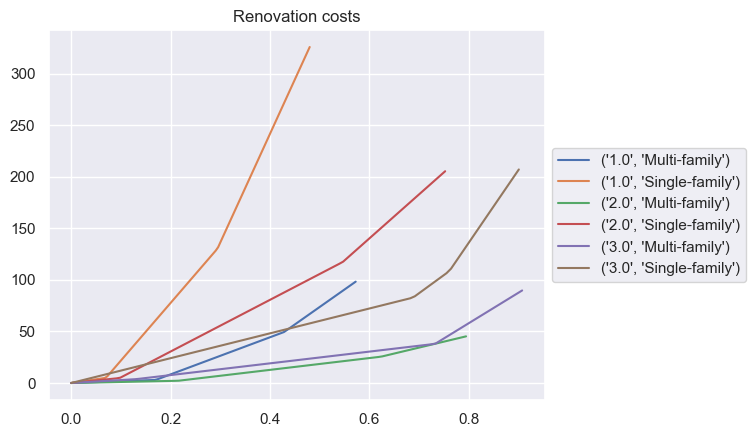

In [3]:
hourly_profile_test = heating_hourly_profile(method="valentin", percentage=0)

# TODO: attention au choix de hourly profile !!
# ['Occupancy status', 'Income owner', 'Income tenant', 'Housing type', 'Heating system']
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', "Housing type"], climate=2006, smooth=False, building_stock="medium_3",
                                      hourly_profile=hourly_profile_test)
dict_heat = process_heating_need(dict_heat, climate=2006)
linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(dict_cost, number_of_segments=3, plot=True, plot_tot=True)

threshold_linearized_renovation_costs[threshold_linearized_renovation_costs < 0] = 0  # handles cases where the linearization was not perfect

In [4]:
sum([(dict_heat[key]*1).sum() for key in dict_heat.keys()])

192018.42898243916

2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object
2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object


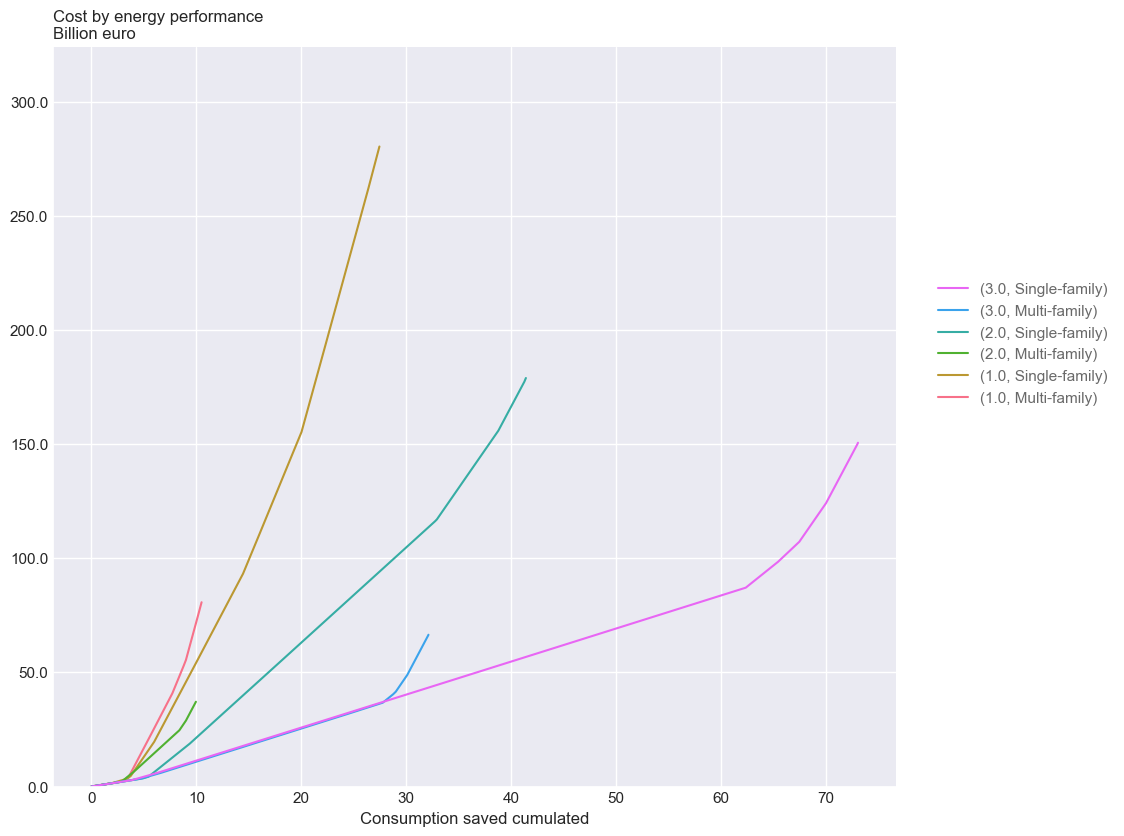

In [5]:
from project.utils import make_plots
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=False, building_stock="medium_3", percent=False)
make_plots(dict_cost, 'Cost by energy performance (Billion euro)', loc="left", left=1.15)

## Process generation output

In [25]:
tmp = m_scc.hourly_generation
climate = 2006
tmp["date"] = tmp.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
tmp = tmp.set_index("date")

In [36]:
h_start, h_end = 0, 60 # winter
# h_start, h_end = 2800, 3000 # spring
# h_start, h_end = 4300, 4500 # summer
# list_hour = tmp.index[h_start:h_end].to_list()
date_start, date_end = datetime.datetime(climate, 2, 15, 0), datetime.datetime(climate, 2, 17, 23)
list_time = tmp.index[(tmp.index > date_start) & (tmp.index < date_end)].to_list()

prod_label = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification",
              "ocgt", "ccgt", "methanation", "electrolysis", "battery1", "battery4", "hydrogen", "methane", "phs"]
prod_label = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "nuclear", "methanization", "pyrogazification", "ocgt", "ccgt"]
prod_label = ["offshore_f", "offshore_g", "onshore", "nuclear", "methanization", "pyrogazification", "ocgt", "ccgt", "methanation"]
# list_prod = [tmp[key].iloc[h_start:h_end].to_list() for key in prod_label]
list_prod = [tmp[key][list_time].to_list() for key in prod_label]

str_label = ["hydrogen", "methane", "hydrogen_in", "methane_in", "electrolysis"]
list_str = [tmp[key][list_time].to_list() for key in str_label]


methane_label = ["methane", "methane_in"]
list_methane = [tmp[key][list_time].to_list() for key in methane_label]

gas_label = ["methane", "methane_in", "methanization", "pyrogazification"]
list_gas = [tmp[key][list_time].to_list() for key in gas_label]

single_tec_label = ["electrolysis"]
list_single_tec = [tmp[key][list_time].to_list() for key in single_tec_label]



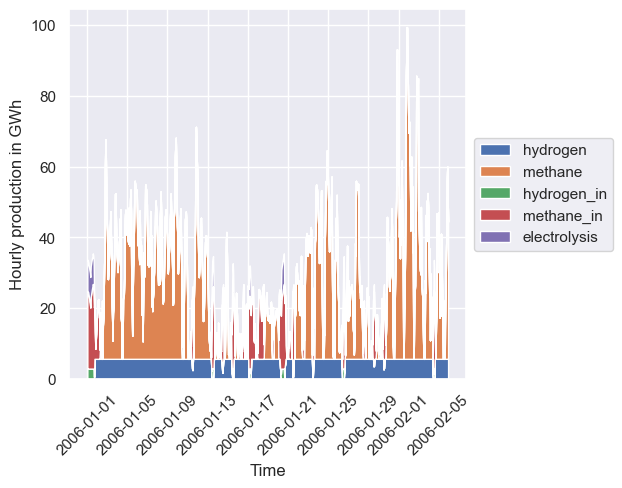

In [46]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_str, labels=str_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# ax.set_ylim(0,10)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

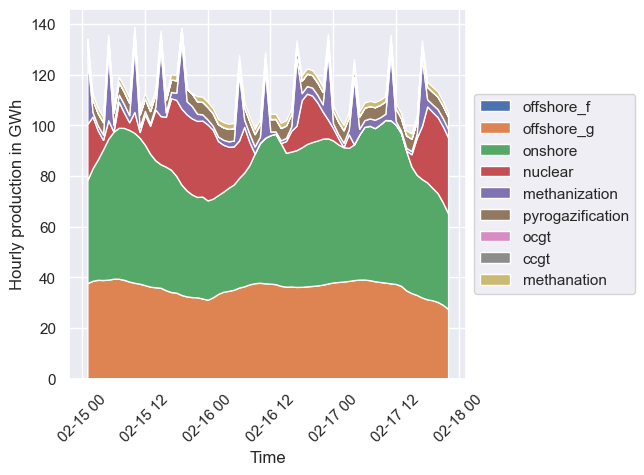

In [37]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_prod, labels=prod_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

In [13]:
list_methane[1]

[19.504193852530864,
 19.310528146210512,
 16.982929174480464,
 14.074685041457915,
 11.166440908435423,
 5.930597803680282,
 2.3622818239011742,
 0.0,
 4.957837541627761,
 10.00013225928534,
 17.176477561575464,
 20.49330699764909,
 21.07395215893909,
 21.145978703969938,
 19.270497774879285,
 18.087718923440704,
 8.583774649418036,
 1.0563962108442517,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.102829904838295,
 8.279878177996544,
 10.18077027991935,
 8.102425901397009,
 6.378216450793781,
 2.291691388141949,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.506035585056485,
 4.575407969507653,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.871290454944525,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

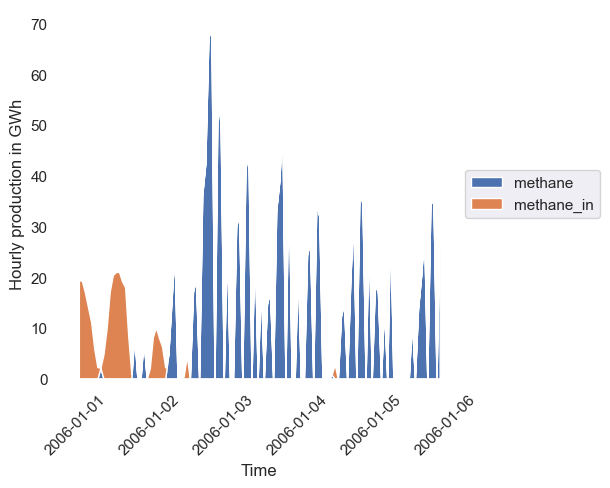

In [11]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_methane, labels=methane_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

In [369]:
list_single_tec

[[9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  4.697509106381841,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
 

In [34]:
tmp[["hydrogen", "hydrogen_in", "hydrogen_charge", "electrolysis"]]

,hydrogen,hydrogen_in,hydrogen_charge,electrolysis
date,,,,
2006-01-01 00:00:00,0.0,3.472742,7321.801839,9.180505
2006-01-01 01:00:00,0.0,3.472742,7325.274581,9.180505
2006-01-01 02:00:00,0.0,3.472742,7328.747323,9.180505
2006-01-01 03:00:00,0.0,3.472742,7332.220065,9.180505
2006-01-01 04:00:00,0.0,3.472742,7335.692807,9.180505
...,...,...,...,...
2006-12-31 19:00:00,0.0,3.472742,7304.438129,9.180505
2006-12-31 20:00:00,0.0,3.472742,7307.910871,9.180505
2006-12-31 21:00:00,0.0,3.472742,7311.383613,9.180505


In [20]:
tmp[["heat_demand", "CH4_demand", "elec_demand", "methane", "methane_in", "methane_charge", "methanization", "pyrogazification", "methanation"]]

,heat_demand,CH4_demand,elec_demand,methane,methane_in,methane_charge,methanization,pyrogazification,methanation
date,,,,,,,,,
2006-01-01 00:00:00,49.101582,14.129032,69.712739,0.0,31.053853,14101.202260,34.209394,7.990868,2.982624
2006-01-01 01:00:00,54.713191,15.058065,65.166886,0.0,30.124820,14132.256113,34.209394,7.990868,2.982624
2006-01-01 02:00:00,57.518995,15.522581,59.364789,0.0,29.660304,14162.380933,34.209394,7.990868,2.982624
2006-01-01 03:00:00,58.921898,15.754839,56.803051,0.0,29.428046,14192.041238,34.209394,7.990868,2.982624
2006-01-01 04:00:00,64.533507,16.683871,53.313940,0.0,28.499014,14221.469284,34.209394,7.990868,2.982624
...,...,...,...,...,...,...,...,...,...
2006-12-31 19:00:00,39.539773,14.729032,71.801487,0.0,30.453853,13945.100739,34.209394,7.990868,2.982624
2006-12-31 20:00:00,35.682234,13.877419,75.025726,0.0,31.305466,13975.554591,34.209394,7.990868,2.982624
2006-12-31 21:00:00,32.789080,13.238710,74.135638,0.0,31.944175,14006.860057,34.209394,7.990868,2.982624


In [30]:
tmp[["heat_demand", "CH4_demand", "elec_demand", "methane", "methane_in", "methane_charge", "methanization", "pyrogazification", "methanation"]]

,heat_demand,CH4_demand,elec_demand,methane,methane_in,methane_charge,methanization,pyrogazification,methanation
date,,,,,,,,,
2006-01-01 00:00:00,58.029142,0,69.712739,0.0,0.0,0.0,7.683871,3.305333,3.139829
2006-01-01 01:00:00,64.661044,1,65.166886,0.0,0.0,0.0,8.612903,3.305333,3.139829
2006-01-01 02:00:00,67.976995,2,59.364789,0.0,0.0,0.0,9.077419,3.305333,3.139829
2006-01-01 03:00:00,69.634970,3,56.803051,0.0,0.0,0.0,9.309677,3.305333,3.139829
2006-01-01 04:00:00,76.266872,4,53.313940,0.0,0.0,0.0,15.062244,3.305333,3.139829
...,...,...,...,...,...,...,...,...,...
2006-12-31 19:00:00,46.728823,8755,71.801487,0.0,0.0,0.0,8.283871,3.305333,3.139829
2006-12-31 20:00:00,42.169913,8756,75.025726,0.0,0.0,0.0,7.432258,3.305333,3.139829
2006-12-31 21:00:00,38.750731,8757,74.135638,0.0,0.0,0.0,6.793548,3.305333,3.139829


In [15]:
tmp[["elec_demand", "battery1", "battery4", "phs", "battery1_in", "battery4_in", "phs_in"]]

,elec_demand,battery1,battery4,phs,battery1_in,battery4_in,phs_in
date,,,,,,,
2006-01-01 00:00:00,69.712739,0.000000,6.839157,0.0,0.0,0.00000,0.000000
2006-01-01 01:00:00,65.166886,0.000000,6.160698,0.0,0.0,0.00000,0.000000
2006-01-01 02:00:00,59.364789,0.000000,2.664485,0.0,0.0,0.00000,0.000000
2006-01-01 03:00:00,56.803051,0.305741,1.314967,0.0,0.0,0.00000,0.000000
2006-01-01 04:00:00,53.313940,0.000000,0.305752,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...
2006-12-31 19:00:00,71.801487,0.000000,0.000000,0.0,0.0,0.00000,0.000000
2006-12-31 20:00:00,75.025726,0.000000,0.000000,0.0,0.0,0.00000,0.000000
2006-12-31 21:00:00,74.135638,0.000000,0.000000,0.0,0.0,0.00000,0.000000


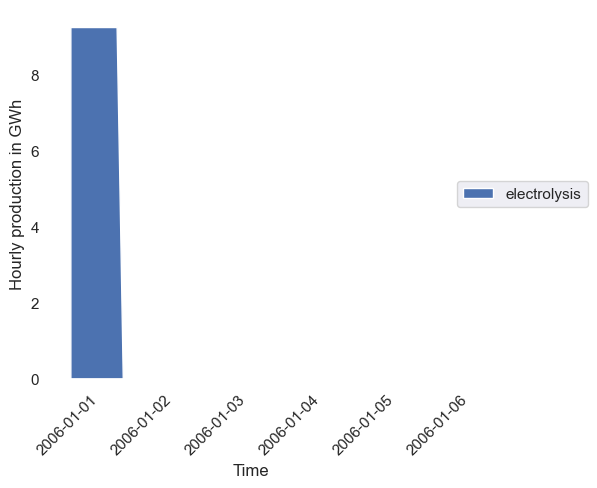

In [368]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_single_tec, labels=single_tec_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

# Run model

In [7]:
list_scc = [0, 100, 200, 300, 400, 500]
list_social_cost = []
list_technical_cost = []
list_emissions = []
list_primary_production = []
list_heat_generation = []
renovation_rate_df = pd.DataFrame(index=list(dict_heat.keys()), dtype=float)
reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

dict_heat_modif = {key: dict_heat[key]*1.1 for key in dict_heat.keys()}  # TODO: a enlever, permet de voir l'impact d'augmenter le besoin en chaleur

# we add hourly heat profile
hourly_gas = create_hourly_residential_demand_profile(total_consumption=25*1e3, method="valentin")  # value for gas heating demand in tertiary sector
hourly_ECS = pd.Series(2.5, index=hourly_gas.index)  # may include industry as well (if just tertiary + residential ECS, we get a total of 22TWh per year, or 2.5GWh per hour)
# hourly_ECS = pd.Series(13, index=hourly_gas.index)  # may include industry as well (if just tertiary + residential ECS, we get a total of 22TWh per year, or 2.5GWh per hour)
hourly_CH4_gas = hourly_gas + hourly_ECS

scenario_cost_high = {
    "capex": {
        "heat_pump": 1050,  # change back to actual level of price
        "gas_boiler": 300,  # hypothesis Zeyen
        "fuel_boiler": 300,  # hypothesis Zeyen
        "wood_boiler": 300,  # hypothesis Zeyen
        "resistive": 100,
        # "offshore_f": 2900,  # change back to 3600
        # "offshore_g": 2300,
        # "nuclear": 4500,  # change back to 5500
        # "onshore": 900,
        "methanation": 1000  # trying a method similar to zeyen
    } ,
    "fOM": {
        "gas_boiler": 21  # hypothesis Zeyen
    } ,
    "vOM": {
        "heat_pump": 0.002,  # hypothesis Zeyen
        # "natural_gas": 0.032
    },
    "conversion_efficiency": {
        "gas_boiler": 0.75,
        # "methanation": 0.5  # trying a method similar to zeyen
    },
    "miscellaneous": {
        "max_methanization": 50,
        "max_pyrogazification": 50,
        "lifetime_renov": 40
    },
    "maximum_capacity": {
        "nuclear": 30,
        "offshore_f": 20,  # initially 20
        "offshore_g": 40,  # initially 40
        # "phs": 8
    },
    "fix_capa": {
        "h2_ccgt": 0,
        # "nuclear": 0
        # "methane": 0,  # we test when we do not allow for hydrogen/methane storage
        # "hydrogen": 0,
        # "battery1": 0,
        # "battery4": 0,
        # "methanation": 4,
        # "pyrogazification": 0,
        # "methanization": 0
    }
}  # we increase prices to check the impact on the output

for scc in list_scc:
    print(f"Social cost of carbon: {scc}")
    m_scc = ModelEOLES(name="test", config=config, path="eoles/outputs", logger=logger, nb_years=1, heating_demand=dict_heat_modif, nb_linearize=3,
                       linearized_renovation_costs=linearized_renovation_costs, threshold_linearized_renovation_costs=threshold_linearized_renovation_costs,
                       social_cost_of_carbon=scc, year=2050, scenario_cost=scenario_cost_high, hp_hourly=True, renov=None,
                       hourly_heat_gas=hourly_CH4_gas)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    list_social_cost.append(m_scc.objective)
    list_technical_cost.append(m_scc.technical_cost)
    list_emissions.append(m_scc.emissions)

    list_primary_production.append(m_scc.primary_generation.reindex(reindex_primary_prod).to_list())
    list_heat_generation.append(m_scc.heat_generation.reindex(reindex_heat_prod).to_list())
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().rename(columns={0: scc})], axis=1)

Social cost of carbon: 0


2022-12-13 15:23:19,505 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 15:23:45,606 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 100


2022-12-13 15:24:01,045 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 15:24:37,133 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 200


2022-12-13 15:24:52,451 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 15:25:30,562 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 300


2022-12-13 15:25:45,880 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 15:26:19,211 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 400


2022-12-13 15:26:34,793 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 15:27:20,071 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 500


2022-12-13 15:27:35,358 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 15:28:24,057 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


In [64]:
m_scc.renovation_rates.to_frame().rename(columns={0: scc})

500
1.0 Multi-family   0.169990
    Single-family  0.070004
2.0 Multi-family   0.215392
    Single-family  0.097347
3.0 Multi-family   0.732042
    Single-family  0.000000

# Post-processing

## Model output

In [40]:
m_scc.capacities

offshore_f            0.000000
offshore_g           40.000000
onshore              80.000000
pv_g                 66.100440
pv_c                  0.000000
river                 7.500000
lake                 12.855000
methanization        26.713423
ocgt                 31.873713
ccgt                 18.103763
nuclear              30.000000
h2_ccgt               0.000000
phs                   7.200000
battery1              0.000000
battery4              0.000000
methanation           2.025622
pyrogazification      4.919491
electrolysis          8.863514
natural_gas           0.000000
hydrogen              5.707763
methane             123.637433
heat_pump            42.559227
gas_boiler           24.694220
resistive            12.990633
fuel_boiler           2.626273
wood_boiler           0.000000
dtype: float64

In [41]:
m_scc.objective

53.9624448579162

In [13]:
m_scc.objective

58.88665557240223

In [5]:
m_scc.objective

62.00361238170278

In [5]:
m_scc.objective

62.115950057324284

In [5]:
m_scc.objective

62.311964784936954

In [128]:
H2_spot_price = [1e6 * m_scc.model.dual[m_scc.model.methane_balance_constraint[h]] for h in m_scc.model.h]

In [130]:
np.std(H2_spot_price)

7.8422711620413486

In [131]:
m_scc.lcoe_per_tec

{'offshore_f': 56.542210329277765,
 'offshore_g': 37.42157167119335,
 'onshore': 34.275185368784854,
 'pv_g': 26.682669110769986,
 'pv_c': nan,
 'river': 43.50947140653866,
 'lake': 54.00642398372373,
 'nuclear': 92.92547360996893,
 'ocgt': 1024.921131046005,
 'ccgt': 356.79492664156174,
 'h2_ccgt': nan,
 'methanization': 61.211903432858904,
 'pyrogazification': 81.59902891358317}

In [33]:
m_scc.storage_annuities

0
battery1    24.278262
battery4    14.281330
phs          1.194211
hydrogen     0.069679
methane      0.061392
Name: 1, dtype: float64

In [27]:
m_scc.capacities

offshore_f            6.000000
offshore_g           18.543614
onshore              62.500000
pv_g                 91.750688
pv_c                  0.000000
river                 7.500000
lake                 12.855000
methanization        19.289815
ocgt                 12.869390
ccgt                 23.168061
nuclear              28.444216
h2_ccgt               0.000000
phs                   7.200000
battery1              0.171078
battery4             10.242429
methanation           3.115719
pyrogazification      2.283105
electrolysis         11.415525
natural_gas         109.767051
hydrogen              5.707763
methane             109.129101
heat_pump            45.160335
gas_boiler           35.959415
resistive            16.432595
fuel_boiler           0.000000
wood_boiler           1.255441
dtype: float64

In [161]:
m_scc.energy_capacity

phs           135.500000
battery1        0.155444
battery4       22.937492
hydrogen     9034.602800
methane     24100.137100
dtype: float64

In [9]:
m_scc.generation_per_technology

{'offshore_f': 0.0,
 'offshore_g': 184.1058628575212,
 'onshore': 227.55635575911973,
 'pv_g': 93.99447090822221,
 'pv_c': 0.0,
 'river': 28.48260030787517,
 'lake': 15.302186369999816,
 'methanization': 50.00000000000116,
 'ocgt': 2.2448511463921372,
 'ccgt': 15.78309125886428,
 'nuclear': 176.71369704104728,
 'h2_ccgt': 0.0,
 'phs': 15.522812968519762,
 'battery1': 0.0,
 'battery4': 0.0,
 'methanation': 12.900000000001148,
 'pyrogazification': 43.09466855474686,
 'electrolysis': 50.00000000000055,
 'natural_gas': 0.0,
 'hydrogen': 16.001742767337788,
 'methane': 29.46168893107884,
 'heat_pump': 146.21227161293493,
 'gas_boiler': 19.344680175965937,
 'resistive': 10.082902610218222,
 'fuel_boiler': 0.08936830877228556,
 'wood_boiler': 0.0}

In [6]:
m_scc.generation_per_technology

{'offshore_f': 0.0,
 'offshore_g': 184.1058628575212,
 'onshore': 227.55635575911973,
 'pv_g': 98.73696706513691,
 'pv_c': 0.0,
 'river': 28.48260030787517,
 'lake': 15.302186369999793,
 'methanization': 35.000000000000895,
 'ocgt': 2.255854881814176,
 'ccgt': 16.15760335062839,
 'nuclear': 169.3591153768542,
 'h2_ccgt': 0.0,
 'phs': 15.38259908257326,
 'battery1': 0.1003818390324866,
 'battery4': 0.0,
 'methanation': 7.524999999999078,
 'pyrogazification': 35.000000000000554,
 'electrolysis': 50.000000000003354,
 'natural_gas': 26.128933194452983,
 'hydrogen': 14.898477493090288,
 'methane': 17.21048400349685,
 'heat_pump': 148.6240474209949,
 'gas_boiler': 17.07571758371914,
 'resistive': 10.006244000217997,
 'fuel_boiler': 0.0,
 'wood_boiler': 0.0}

In [24]:
m_scc.generation_per_technology

{'offshore_f': 0.0,
 'offshore_g': 184.1058628575212,
 'onshore': 227.55635575911973,
 'pv_g': 93.9571574392811,
 'pv_c': 0.0,
 'river': 28.48260030787517,
 'lake': 15.302186369999806,
 'methanization': 49.999999999998096,
 'ocgt': 2.2696223332944347,
 'ccgt': 15.663978362367418,
 'nuclear': 176.7360934699063,
 'h2_ccgt': 0.0,
 'phs': 15.469455320186116,
 'battery1': 0.0,
 'battery4': 0.0,
 'methanation': 12.900000000000457,
 'pyrogazification': 43.16874396556578,
 'electrolysis': 49.999999999997115,
 'natural_gas': 0.0,
 'hydrogen': 16.004977842204934,
 'methane': 29.510824796524663,
 'heat_pump': 146.19625856570138,
 'gas_boiler': 19.510518254033805,
 'resistive': 10.000496363515444,
 'fuel_boiler': 0.0,
 'wood_boiler': 0.0}

In [9]:
sns.set_theme()

## Graphs

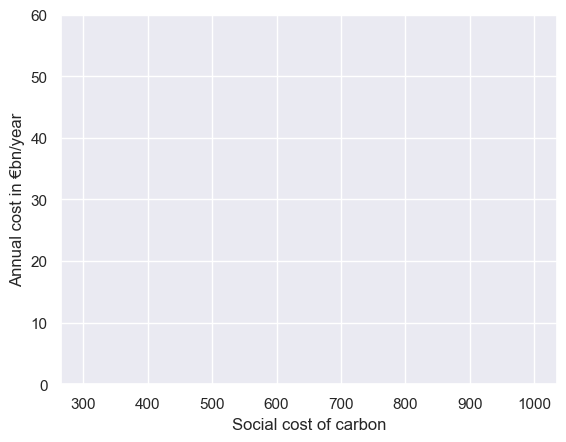

In [75]:
plt.plot(list_scc, list_social_cost)
plt.ylim(0, 60)
plt.ylabel("Annual cost in €bn/year")
plt.xlabel("Social cost of carbon")
plt.show()

In [8]:
m_scc.summary

weighted_price_demand           70.864314
weighted_price_generation       66.541615
elec_demand_tot                561.970000
hydrogen_demand_tot              0.050000
methane_demand_tot              70.560000
heat_demand_tot                192.018429
offshore_f                       0.000000
offshore_g                      92.052931
onshore                        227.556356
pv_g                           120.643922
pv_c                             0.000000
river                           28.482600
lake                            15.302186
methanization                   30.000000
ocgt                             1.392751
ccgt                             1.761506
nuclear                        208.820529
h2_ccgt                         29.758709
phs                             15.765215
battery1                         0.396137
battery4                         2.346426
methanation                      7.740000
pyrogazification                70.000000
electrolysis                    52

In [20]:
m_scc.capacities

offshore_f            0.000000
offshore_g           40.000000
onshore              80.000000
pv_g                 84.240429
pv_c                  0.000000
river                 7.500000
lake                 12.855000
methanization        26.434989
ocgt                 27.059682
ccgt                 20.998027
nuclear              26.004576
h2_ccgt               0.000000
phs                   7.200000
battery1              1.299728
battery4              5.339861
methanation           2.085625
pyrogazification      5.645831
electrolysis          9.253144
natural_gas           0.000000
hydrogen              5.707763
methane             119.802235
heat_pump            43.257254
gas_boiler           27.371815
resistive            12.910243
fuel_boiler           0.000000
wood_boiler           0.000000
dtype: float64

### Primary production

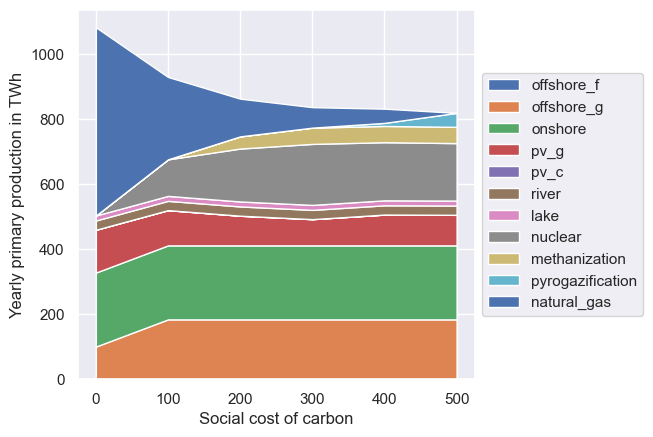

In [42]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

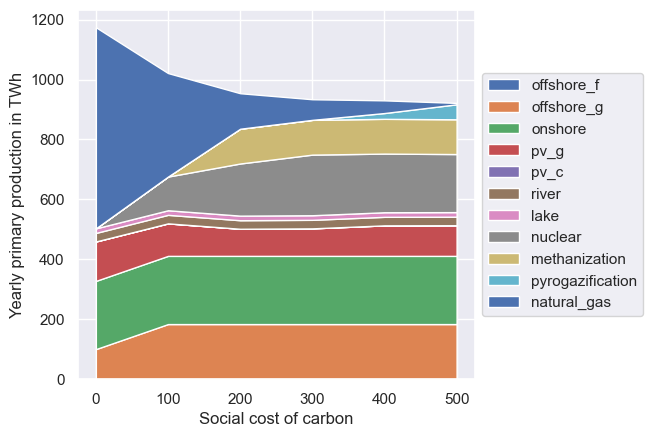

In [22]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

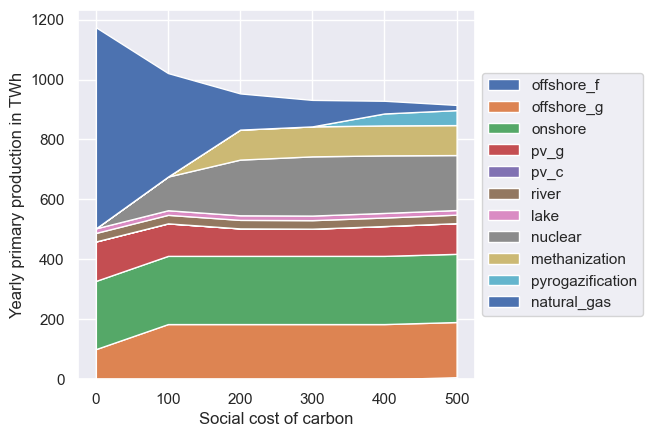

In [18]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

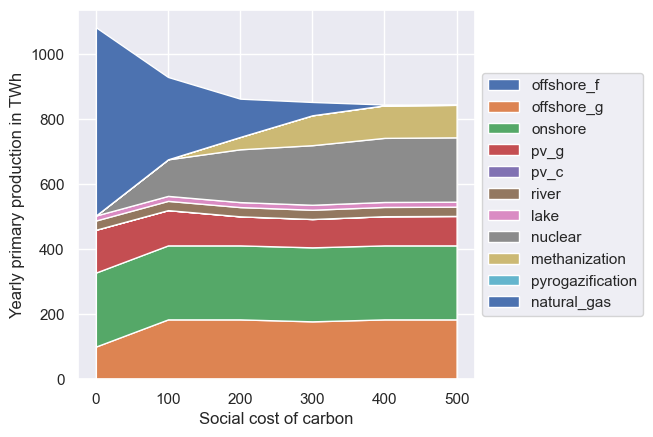

In [14]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

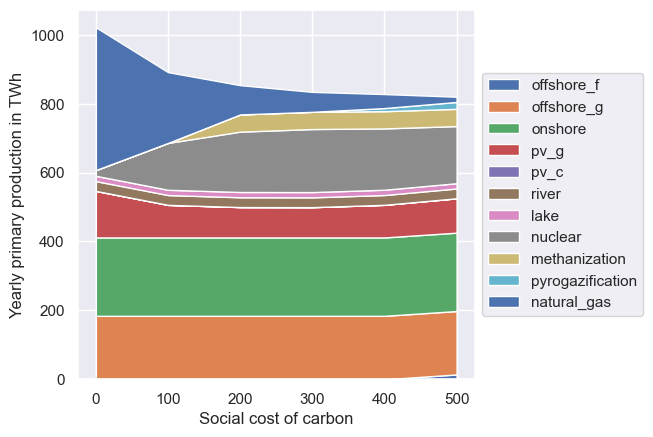

In [40]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

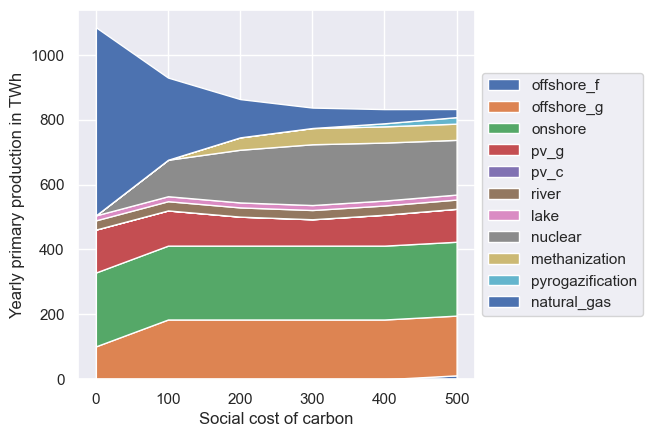

In [34]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

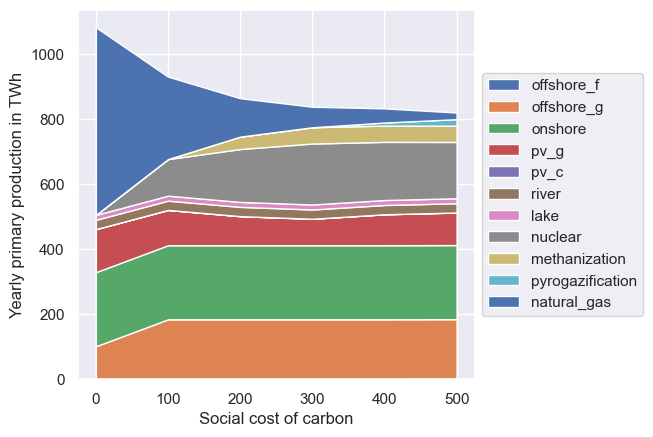

In [25]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

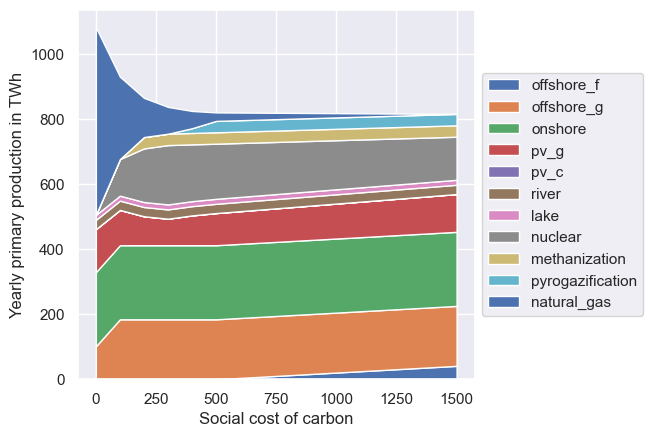

In [26]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

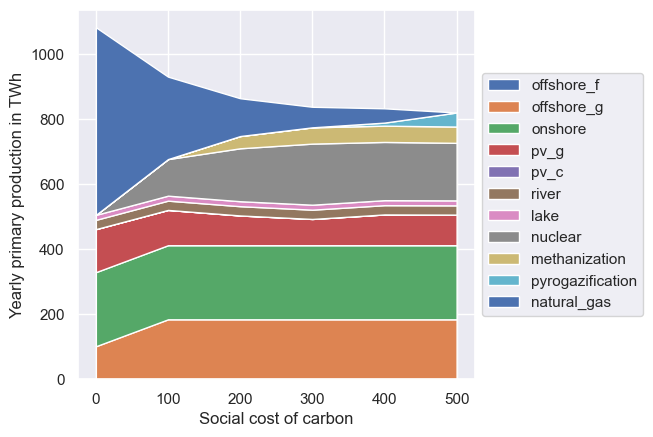

In [21]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

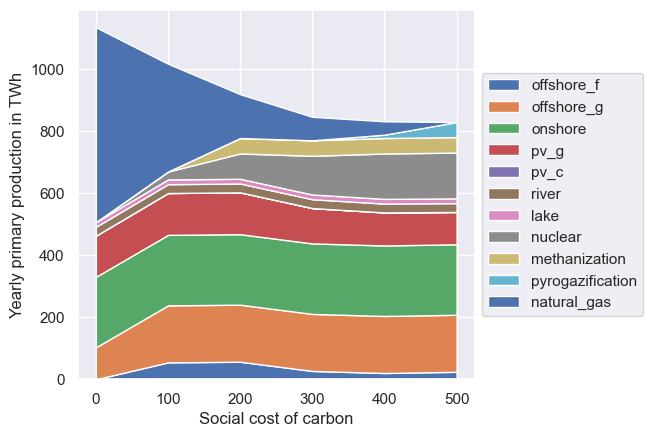

In [10]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

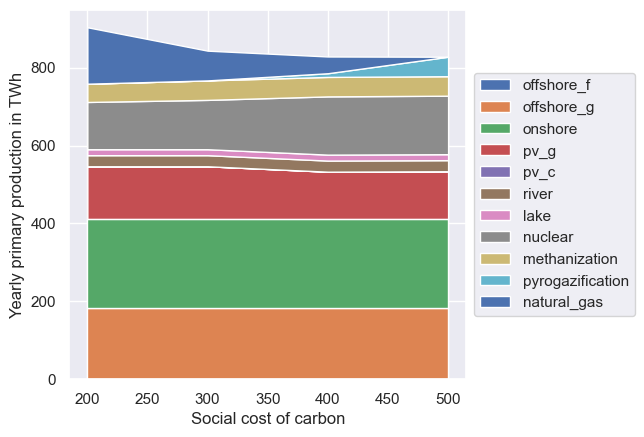

In [6]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

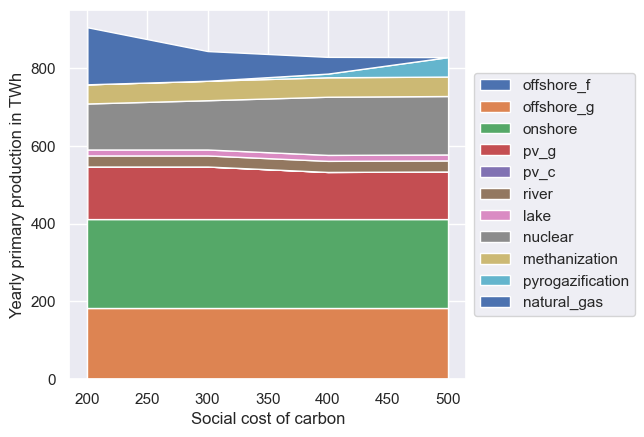

In [163]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [8]:
m_scc.renovation_rates_detailed

('1.0', 'Multi-family')_0     0.170001
('1.0', 'Multi-family')_1     0.000000
('1.0', 'Multi-family')_2     0.000000
('1.0', 'Single-family')_0    0.070006
('1.0', 'Single-family')_1    0.000000
('1.0', 'Single-family')_2    0.000000
('2.0', 'Multi-family')_0     0.215399
('2.0', 'Multi-family')_1     0.000000
('2.0', 'Multi-family')_2     0.000000
('2.0', 'Single-family')_0    0.097347
('2.0', 'Single-family')_1    0.000000
('2.0', 'Single-family')_2    0.000000
('3.0', 'Multi-family')_0     0.131112
('3.0', 'Multi-family')_1     0.600929
('3.0', 'Multi-family')_2     0.000000
('3.0', 'Single-family')_0    0.687661
('3.0', 'Single-family')_1    0.000000
('3.0', 'Single-family')_2    0.000000
dtype: float64

In [8]:
m_scc.existing_renovation_rate

('1.0', 'Multi-family')_0     0.0
('1.0', 'Multi-family')_1     0.0
('1.0', 'Multi-family')_2     0.0
('1.0', 'Single-family')_0    0.0
('1.0', 'Single-family')_1    0.0
('1.0', 'Single-family')_2    0.0
('2.0', 'Multi-family')_0     0.0
('2.0', 'Multi-family')_1     0.0
('2.0', 'Multi-family')_2     0.0
('2.0', 'Single-family')_0    0.0
('2.0', 'Single-family')_1    0.0
('2.0', 'Single-family')_2    0.0
('3.0', 'Multi-family')_0     0.0
('3.0', 'Multi-family')_1     0.0
('3.0', 'Multi-family')_2     0.0
('3.0', 'Single-family')_0    0.0
('3.0', 'Single-family')_1    0.0
('3.0', 'Single-family')_2    0.0
dtype: float64

In [8]:
m_scc.existing_charging_capacity

0
phs         4.2
battery1    0.0
battery4    0.0
hydrogen    0.0
methane     0.0
Name: 1, dtype: float64

In [14]:
m_scc.charging_capacity

phs          8.000000
battery1     0.155445
battery4     5.734424
hydrogen     5.707763
methane     27.526491
dtype: float64

In [16]:
m_scc.capacities

offshore_f            0.000000
offshore_g           40.000000
onshore              80.000000
pv_g                 86.019345
pv_c                  0.000000
river                 7.500000
lake                 12.855000
methanization        26.341320
ocgt                 27.258718
ccgt                 21.978813
nuclear              25.540883
h2_ccgt               0.000000
phs                   8.000000
battery1              0.155445
battery4              5.734424
methanation           2.090312
pyrogazification      5.707763
electrolysis          9.286818
natural_gas           0.000000
hydrogen              5.707763
methane             121.259189
heat_pump            43.686420
gas_boiler           28.153229
resistive            11.699216
fuel_boiler           0.000000
wood_boiler           0.595786
dtype: float64

In [11]:
8*15/1000

0.12

In [10]:
m_scc.annuities

0
offshore_f          213.242507
offshore_g          136.238269
onshore              72.494203
onshore_V110         57.738746
pv_g                 29.942651
pv_g_ns              29.942651
pv_c                 42.497221
river               150.385051
lake                 49.287543
nuclear             386.422690
ocgt                 38.492497
ccgt                 53.310627
phs                  59.710532
electrolysis         37.268830
hydrogen             24.387790
h2_ccgt              65.157433
methanization        31.004149
battery1             29.990794
battery4             17.613641
methane               0.000000
methanation          58.656498
pyrogazification    209.487493
natural_gas           0.000000
heat_pump            82.536150
resistive             7.860586
gas_boiler           23.581757
fuel_boiler          13.756025
wood_boiler          13.756025
Name: 1, dtype: float64

### Heat production

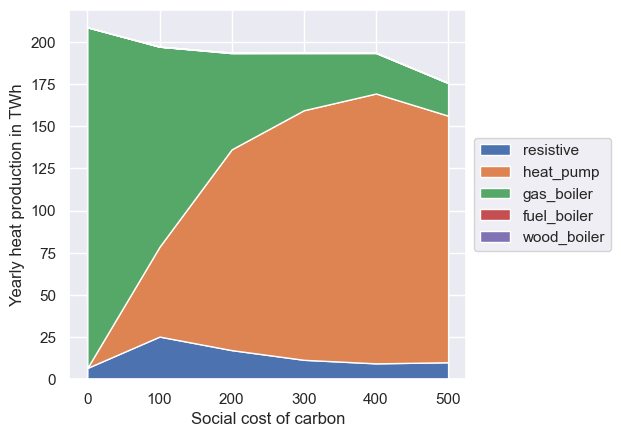

In [43]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

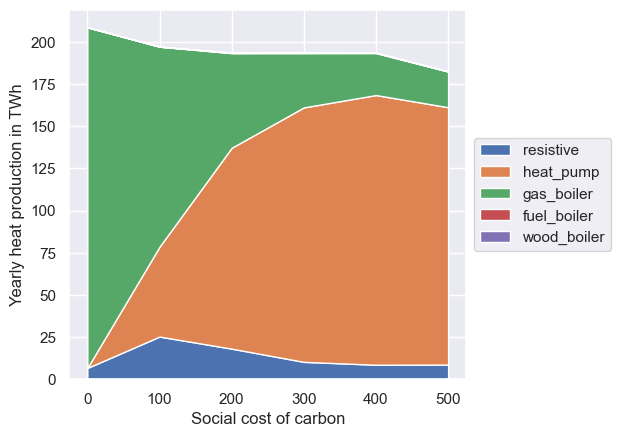

In [23]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

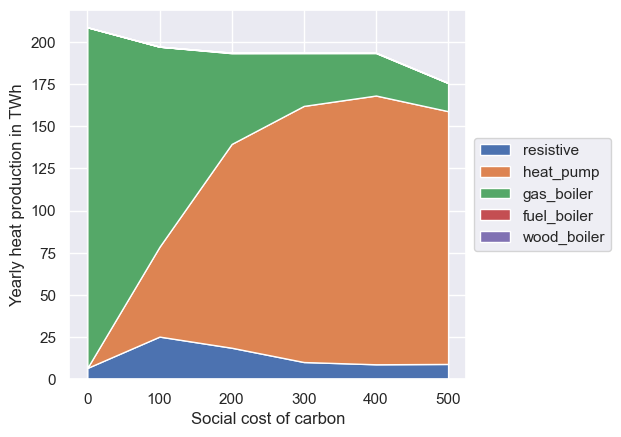

In [19]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

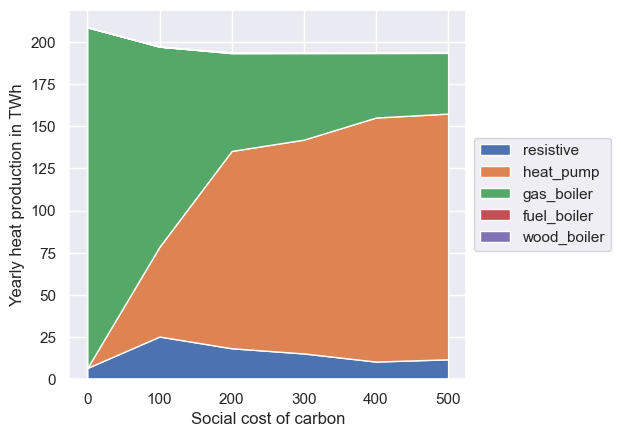

In [15]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

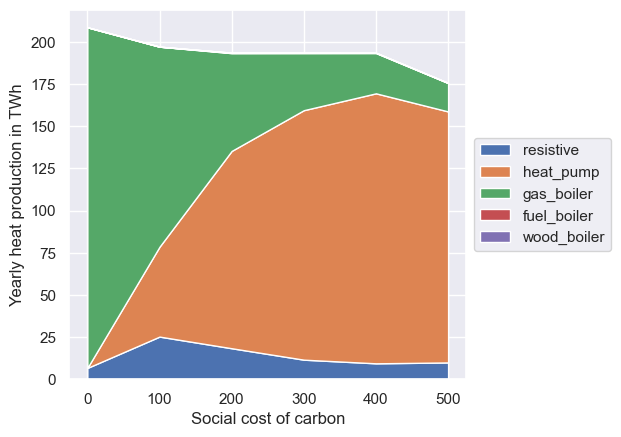

In [11]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

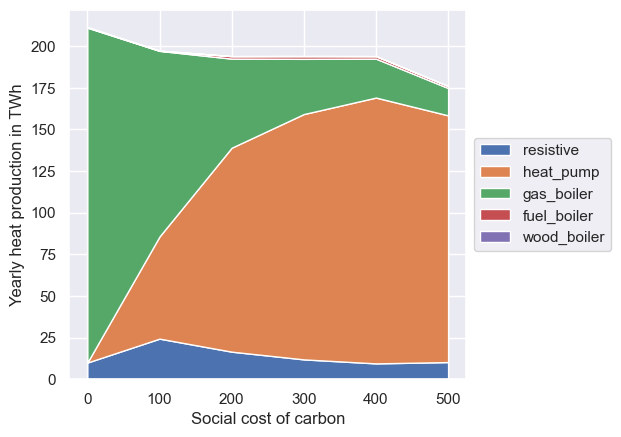

In [6]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

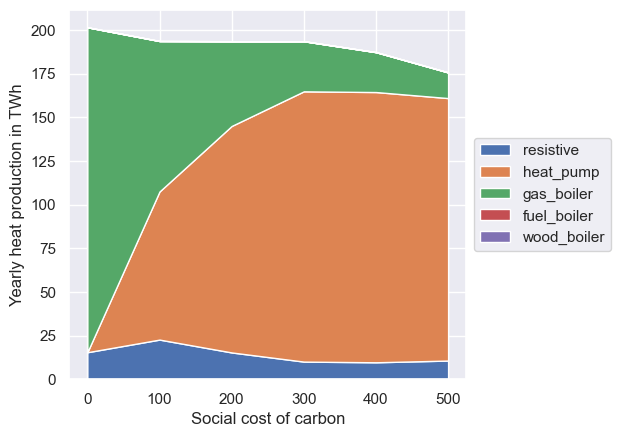

In [41]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

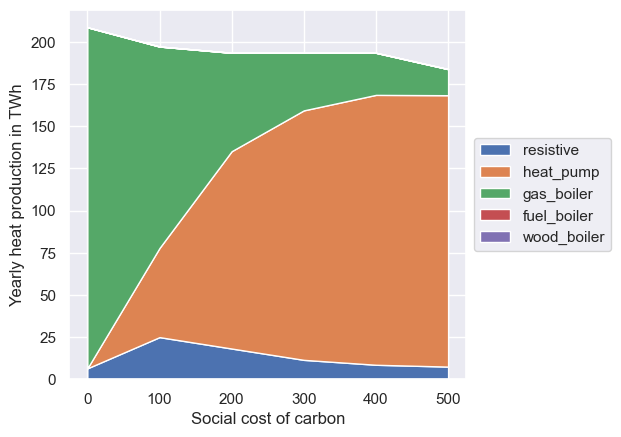

In [38]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

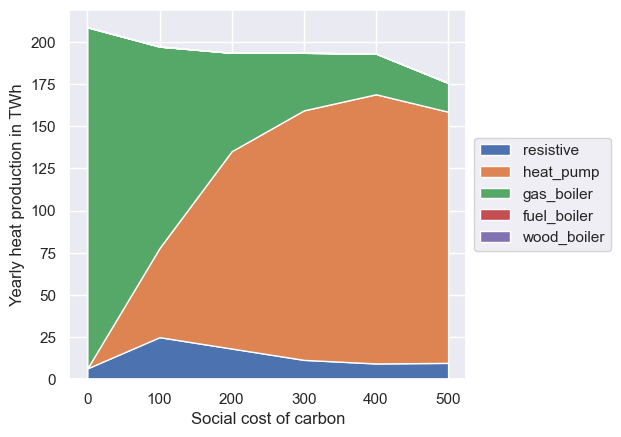

In [26]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

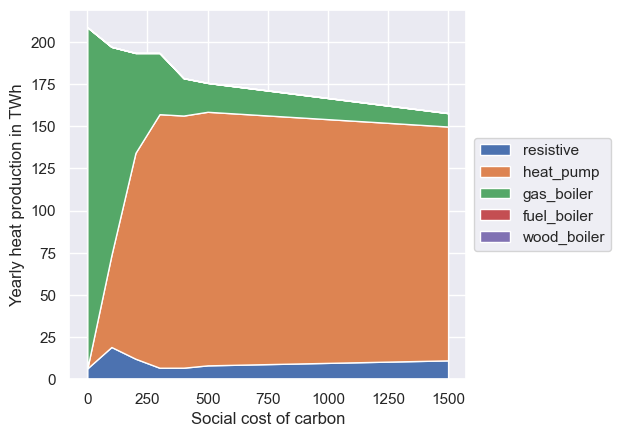

In [65]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

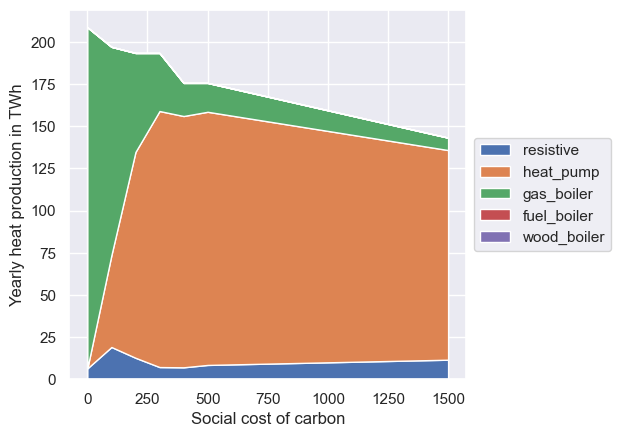

In [31]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

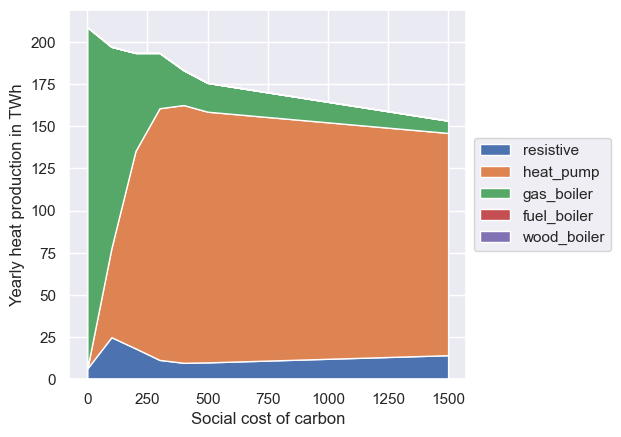

In [25]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

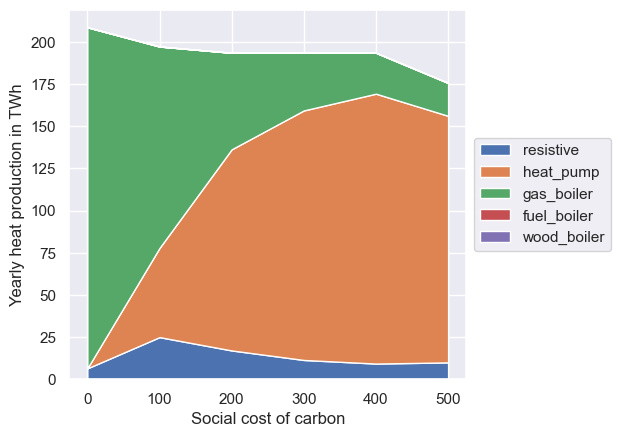

In [22]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

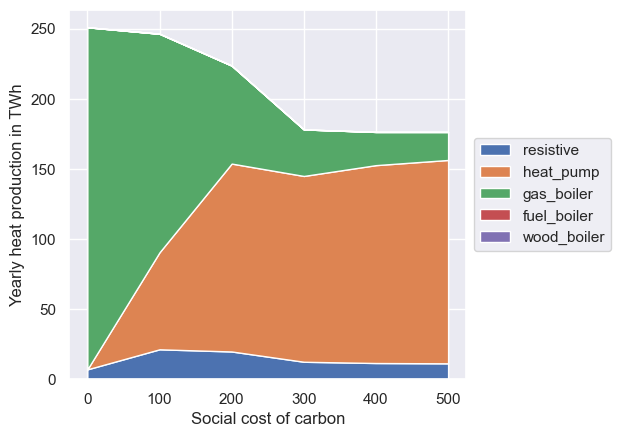

In [11]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

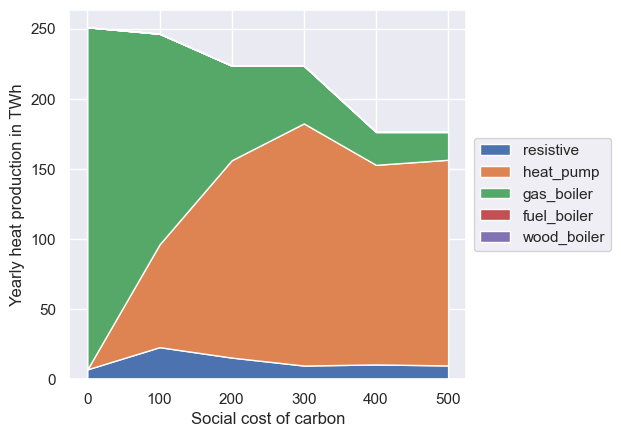

In [7]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

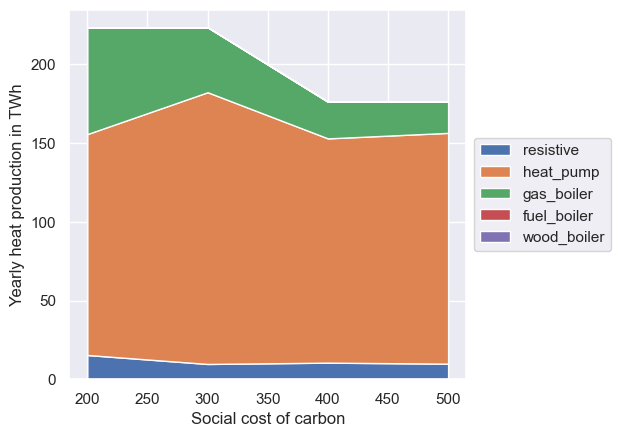

In [28]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

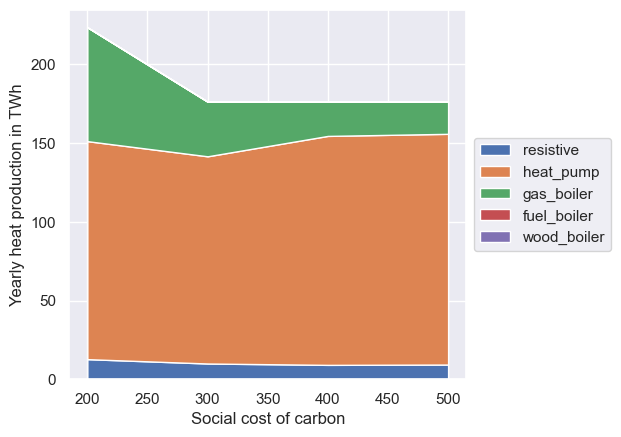

In [24]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

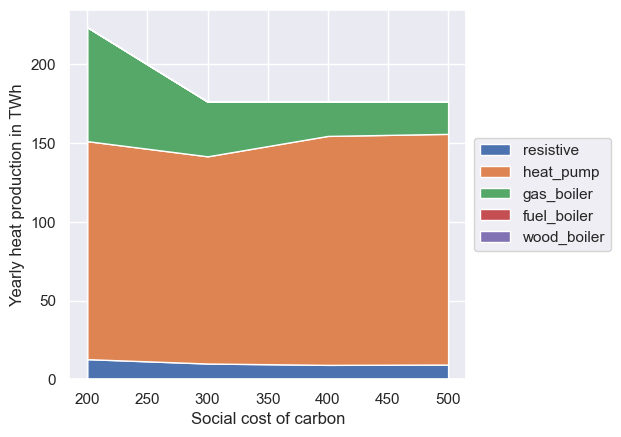

In [6]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

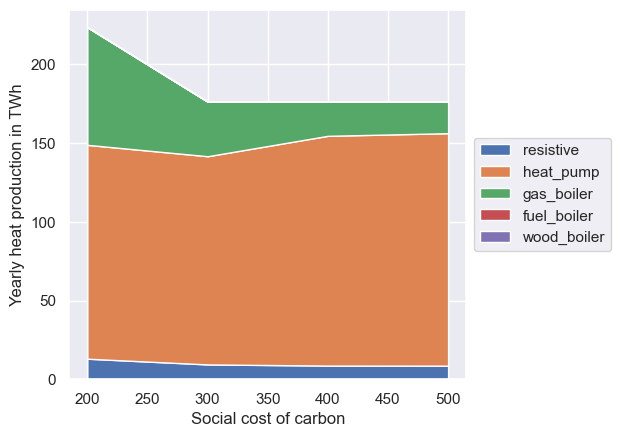

In [7]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

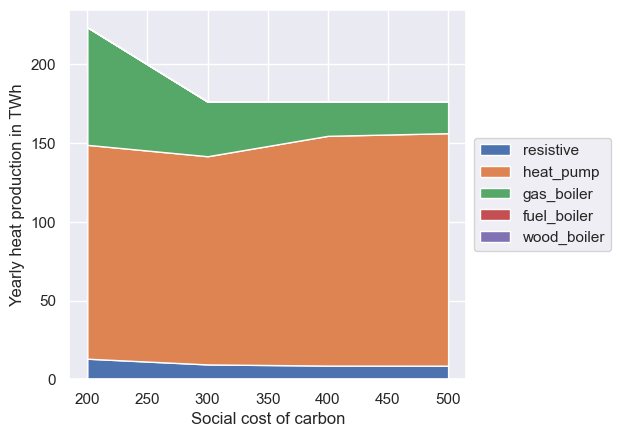

In [164]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [78]:
renovation_rate_df

1.0                        2.0                        3.0  \
  Multi-family Single-family Multi-family Single-family Multi-family   
0     0.000000      0.000000     0.000000      0.000000     0.000000   
1     0.170003      0.000000     0.215394      0.000000     0.131225   
2     0.170003      0.000000     0.215394      0.097347     0.131225   
3     0.170003      0.070006     0.215394      0.097347     0.131225   
4     0.170003      0.070006     0.215394      0.097347     0.131225   
5     0.170003      0.070006     0.215394      0.097347     0.131225   

                 
  Single-family  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
5           0.0

## Renovation

In [27]:
renovation_rate_df_plot = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'scc', 'level_1': 'archetype', 0: 'renovation_rate'})
renovation_rate_df_plot

,scc,archetype,renovation_rate
0,0,"(1.0, Multi-family)",0.000000
1,0,"(1.0, Single-family)",0.000000
2,0,"(2.0, Multi-family)",0.215403
3,0,"(2.0, Single-family)",0.000000
4,0,"(3.0, Multi-family)",0.000000
5,0,"(3.0, Single-family)",0.000000
6,100,"(1.0, Multi-family)",0.169991
7,100,"(1.0, Single-family)",0.000000
8,100,"(2.0, Multi-family)",0.215403
9,100,"(2.0, Single-family)",0.097347


In [28]:
df_heat = pd.Series({key: dict_heat_modif[key].sum() for key in list(dict_heat_modif.keys())}).to_frame().rename(columns={0: "heat_demand"})
df_heat.index = df_heat.index.to_flat_index()
df_heat = df_heat.transpose().stack().reset_index().drop(columns=["level_0"]).rename(columns={'level_1': 'archetype', 0: "heat_demand"})
df_heat

,archetype,heat_demand
0,"(1.0, Multi-family)",19130.761858
1,"(1.0, Single-family)",52012.334347
2,"(2.0, Multi-family)",11683.958581
3,"(2.0, Single-family)",44663.712122
4,"(3.0, Multi-family)",29718.915104
5,"(3.0, Single-family)",54010.589870


In [29]:
heat_and_renov = pd.merge(renovation_rate_df_plot.groupby(["archetype", "scc"])["renovation_rate"].sum().reset_index(), df_heat.groupby("archetype")["heat_demand"].sum().reset_index(),
         on='archetype')
heat_and_renov

,archetype,scc,renovation_rate,heat_demand
0,"(1.0, Multi-family)",0,0.000000,19130.761858
1,"(1.0, Multi-family)",100,0.169991,19130.761858
2,"(1.0, Multi-family)",200,0.169991,19130.761858
3,"(1.0, Multi-family)",300,0.169991,19130.761858
4,"(1.0, Multi-family)",400,0.169991,19130.761858
5,"(1.0, Multi-family)",500,0.169991,19130.761858
6,"(1.0, Single-family)",0,0.000000,52012.334347
7,"(1.0, Single-family)",100,0.000000,52012.334347
8,"(1.0, Single-family)",200,0.070005,52012.334347
9,"(1.0, Single-family)",300,0.070005,52012.334347


In [30]:
heat = {}
for n, g in heat_and_renov.groupby('scc'):
    heat.update({n: g["heat_demand"].sum()})
heat

{0: 211220.27188068302,
 100: 211220.27188068302,
 200: 211220.27188068302,
 300: 211220.27188068302,
 400: 211220.27188068302,
 500: 211220.27188068302}

In [31]:
renov = {}
for n, g in heat_and_renov.groupby('scc'):
    renov.update({n: (g["renovation_rate"] * g["heat_demand"]).sum() / g["heat_demand"].sum()})

renov

{0: 0.011915327685605643,
 100: 0.066354292034317,
 200: 0.08359271771035515,
 300: 0.08359271771035515,
 400: 0.08583669316138393,
 500: 0.1681334498933851}

In [54]:
renov

{0: 0.011914920980491716,
 100: 0.06682689096642885,
 200: 0.0840654568612449,
 300: 0.0840654568612449,
 400: 0.1681385151128662,
 500: 0.1681385151128662,
 1500: 0.3383498072701263}

In [149]:
renovation_rate_df_plot.sort_values(by="renovation_rate", ascending=False)

,scc,level_1,level_2,renovation_rate,archetype
22,500,3.0,Multi-family,0.732041,3.0 Multi-family
4,200,3.0,Multi-family,0.732041,3.0 Multi-family
16,400,3.0,Multi-family,0.732041,3.0 Multi-family
10,300,3.0,Multi-family,0.732041,3.0 Multi-family
23,500,3.0,Single-family,0.687660,3.0 Single-family
17,400,3.0,Single-family,0.687660,3.0 Single-family
11,300,3.0,Single-family,0.687660,3.0 Single-family
14,400,2.0,Multi-family,0.215400,2.0 Multi-family
2,200,2.0,Multi-family,0.215400,2.0 Multi-family
20,500,2.0,Multi-family,0.215400,2.0 Multi-family


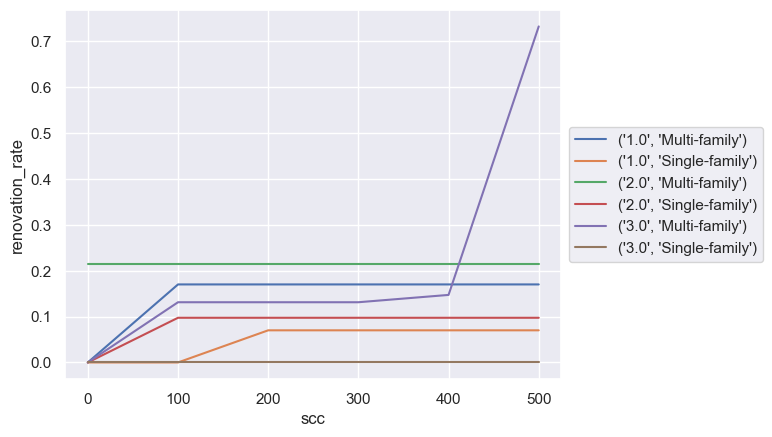

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(renovation_rate_df_plot, x="scc", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

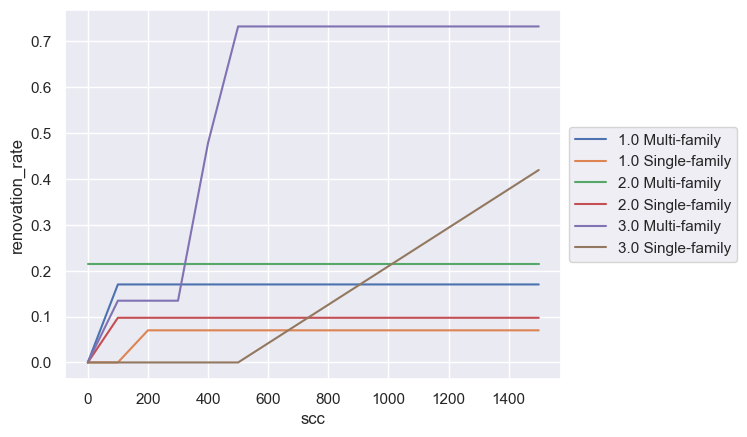

In [24]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(renovation_rate_df_plot, x="scc", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<AxesSubplot:xlabel='scc', ylabel='renovation_rate'>

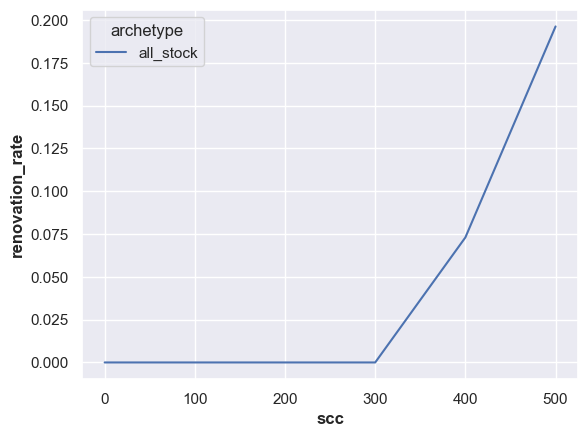

In [48]:
sns.lineplot(renovation_rate_df, x="scc", y="renovation_rate", hue="archetype")

## Process weather data

### Process weather data

In [117]:
from pathlib import Path
from eoles.utils import get_pandas
path_weather = Path("eoles") / "inputs" / "ninja_weather_country_FR_merra-2_population_weighted.csv"
weather = get_pandas(path_weather,
           lambda x: pd.read_csv(x, header=2))
weather["date"] = weather.apply(lambda row: datetime.datetime.strptime(row["time"], '%Y-%m-%d %H:%M:%S'), axis=1)
weather = weather.loc[(weather.date >= datetime.datetime(climate, 1, 1, 0)) & (weather.date <= datetime.datetime(climate, 12, 31, 23))]
weather["day"] = weather.apply(lambda row: row["date"].date(), axis=1)

weather_daily = weather.groupby("day")["temperature"].mean().reset_index().rename(columns={"temperature": "daily_temperature"})

weather = pd.merge(weather, weather_daily, on=["day"])

load_factors = m_scc.load_factors.reset_index().rename(columns={0: "technology", 1: "hour", 2: "capacity_factor"})
load_factors["date"] = load_factors.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)

weather = pd.merge(weather, load_factors.drop(columns=["hour"]), on=["date"])

In [96]:
weather

,time,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density,date,day,daily_temperature,technology,capacity_factor
0,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,offshore_f,0.936250
1,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,offshore_g,0.865143
2,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,onshore,0.511702
3,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,pv_g,0.000000
4,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,pv_c,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2006-12-31 23:00:00,0.574,10.358,0.0,0.0,0.0000,0.0345,0.9614,1.2175,2006-12-31 23:00:00,2006-12-31,8.016542,offshore_g,0.988143
52556,2006-12-31 23:00:00,0.574,10.358,0.0,0.0,0.0000,0.0345,0.9614,1.2175,2006-12-31 23:00:00,2006-12-31,8.016542,onshore,0.818481
52557,2006-12-31 23:00:00,0.574,10.358,0.0,0.0,0.0000,0.0345,0.9614,1.2175,2006-12-31 23:00:00,2006-12-31,8.016542,pv_g,0.000000
52558,2006-12-31 23:00:00,0.574,10.358,0.0,0.0,0.0000,0.0345,0.9614,1.2175,2006-12-31 23:00:00,2006-12-31,8.016542,pv_c,0.000000


In [118]:
# Plot evolution of heating need and temperature
climate = 2006
df_heat_plot = df_heat.rename(columns={"date": "hour"})  # we use previously defined df_heat
df_heat_plot["date"] = df_heat_plot.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
df_heat_plot = df_heat_plot.groupby("date")["heat_demand"].sum().reset_index()

date_start, date_end = datetime.datetime(climate, 1, 16, 0), datetime.datetime(climate, 2, 28, 23)
# list_time = df_heat_plot.index[(df_heat_plot.index > date_start) & (df_heat_plot.index < date_end)].to_list()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


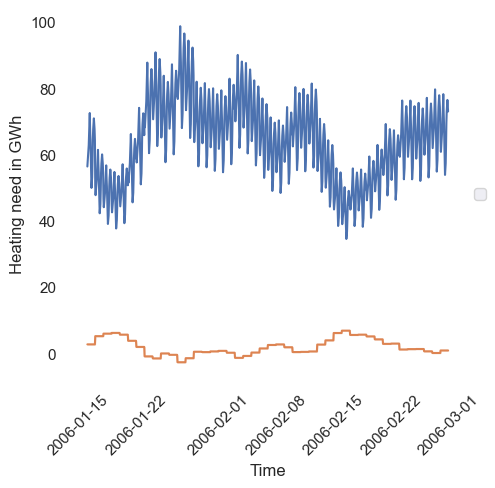

In [119]:
fig = plt.figure()
ax = plt.subplot(111)
# sns.lineplot(df_heat_plot.loc[(df_heat_plot.date > date_start) & (df_heat_plot.date < date_end)], x="date", y="heat_demand", hue="archetype")
sns.lineplot(df_heat_plot.loc[(df_heat_plot.date > date_start) & (df_heat_plot.date < date_end)], x="date", y="heat_demand")  # plot heating need
sns.lineplot(weather.loc[(weather.date > date_start) & (weather.date < date_end)], x="date", y="daily_temperature")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
ax.set_ylabel("Heating need in GWh")
ax.set_xlabel("Time")

# ax2 = ax.twinx()  # add other axis for weather data
# sns.lineplot(weather.loc[(weather.date > date_start) & (weather.date < date_end) & (weather.technology.isin(["offshore_f", "onshore"]))], x="date", y="capacity_factor",
#              hue="technology", ax=ax2)

# ax.set_ylim(0,10)
# Shrink current axis by 20%

plt.show()

### Smooth heating profile

In [120]:
dict_cost_smooth, dict_heat_smooth = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=True, building_stock="medium_3",
                                      hourly_profile=hourly_profile_test)
dict_heat_smooth = process_heating_need(dict_heat_smooth, climate=2006)
dict_heat_modif_smooth = {key: dict_heat_smooth[key]*1.1 for key in dict_heat_smooth.keys()}  # TODO: a enlever, permet de voir l'impact d'augmenter le besoin en chaleur

df_heat_smooth = pd.DataFrame(dict_heat_modif_smooth).stack(
    level=[i for i in range(pd.DataFrame(dict_heat_modif_smooth).columns.nlevels)]).reset_index()
df_heat_smooth["archetype"] = df_heat_smooth.apply(lambda row: row["level_1"] + ' ' + row["level_2"], axis=1)  # should be changed depending on level of multiindex
# df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"], axis=1)  # should be changed depending on level of multiindex
df_heat_smooth = df_heat_smooth.rename(columns={"level_0": "date", 0: "heat_demand"})

# Plot evolution of heating need and temperature

climate = 2006
df_heat_smooth = df_heat_smooth.rename(columns={"date": "hour"})
df_heat_smooth["date"] = df_heat_smooth.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
df_heat_smooth = df_heat_smooth.groupby("date")["heat_demand"].sum().reset_index()


2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object


In [124]:
df_heat_plot.sum()

/var/folders/1c/f0py8khj3bx759_g1q03n6fc0000gn/T/ipykernel_75961/3837886878.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_heat_plot.sum()


heat_demand    211220.271881
dtype: float64

In [123]:
df_heat_smooth.sum()

/var/folders/1c/f0py8khj3bx759_g1q03n6fc0000gn/T/ipykernel_75961/4253487980.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_heat_smooth.sum()


heat_demand    210788.270868
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


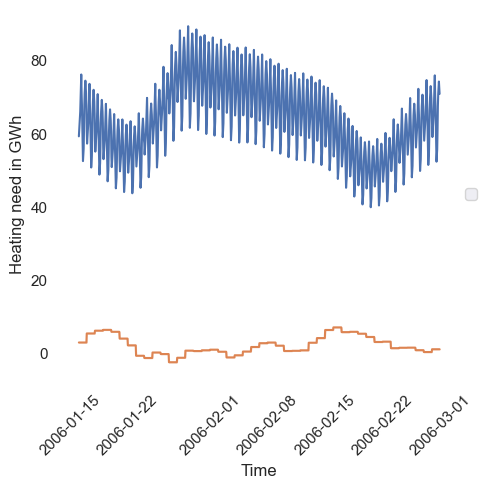

In [121]:
date_start, date_end = datetime.datetime(climate, 1, 16, 0), datetime.datetime(climate, 2, 28, 23)
# list_time = df_heat_plot.index[(df_heat_plot.index > date_start) & (df_heat_plot.index < date_end)].to_list()

fig = plt.figure()
ax = plt.subplot(111)
# sns.lineplot(df_heat_plot.loc[(df_heat_plot.date > date_start) & (df_heat_plot.date < date_end)], x="date", y="heat_demand", hue="archetype")
sns.lineplot(df_heat_smooth.loc[(df_heat_smooth.date > date_start) & (df_heat_smooth.date < date_end)], x="date", y="heat_demand")  # plot heating need
sns.lineplot(weather.loc[(weather.date > date_start) & (weather.date < date_end)], x="date", y="daily_temperature")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
ax.set_ylabel("Heating need in GWh")
ax.set_xlabel("Time")

plt.show()

# Social planner trajectory

2022-12-13 12:20:35,249 - 39897 - log_ - INFO - Creating AgentBuildings object


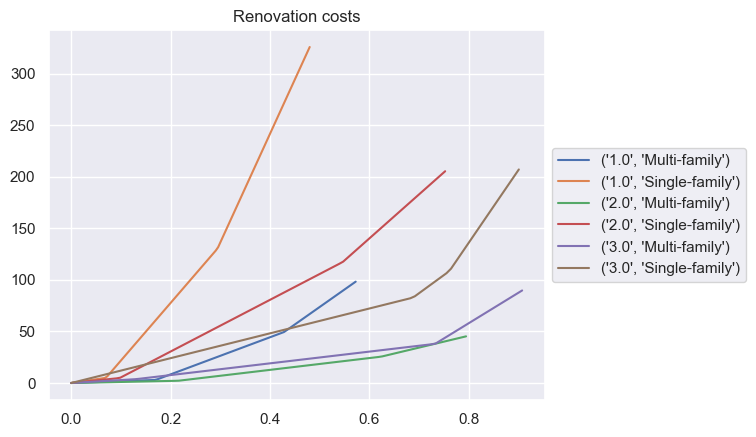

In [2]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

hourly_profile_test = heating_hourly_profile(method="valentin", percentage=0)

# TODO: attention au choix de hourly profile !!
# ['Occupancy status', 'Income owner', 'Income tenant', 'Housing type', 'Heating system']
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', "Housing type"], climate=2006,
                                      smooth=False, building_stock="medium_3", hourly_profile=hourly_profile_test)
dict_heat = process_heating_need(dict_heat, climate=2006)

linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(
    dict_cost, number_of_segments=3, plot=True, plot_tot=True)

threshold_linearized_renovation_costs[
    threshold_linearized_renovation_costs < 0] = 0  # handles cases where the linearization was not perfect


In [3]:
# importing evolution of historical capacity
existing_capacity_historical, existing_charging_capacity_historical, existing_energy_capacity_historical,\
           maximum_capacity_evolution, heating_gas_demand_RTE_timesteps, ECS_gas_demand_RTE_timesteps = load_evolution_data()

# TODO: il faudra ajouter les capacités pour charging et discharging
year = [2025, 2030, 2035, 2040, 2045, 2050]
trajectory_scc = [180, 250, 350, 500, 650, 776]  # from Quinet
# trajectory_scc = [100, 200, 300, 400, 500, 500]  # smaller CO2 cost

# Saving all new installed capacity
new_capacity_tot = pd.Series(0, index=existing_capacity_historical.index, dtype=float)
new_charging_capacity_tot = pd.Series(0, index=existing_charging_capacity_historical.index, dtype=float)
new_energy_capacity_tot = pd.Series(0, index=existing_energy_capacity_historical.index, dtype=float)

# Initialize renovation rate to 0 at first
existing_renovation_rate = pd.Series(0, index=linearized_renovation_costs.index, dtype=float)  # no renovation has been done

reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

capacity_df = pd.DataFrame(index=existing_capacity_historical.index, dtype=float)
new_capacity_df = pd.DataFrame(index=existing_capacity_historical.index, dtype=float)
generation_df = pd.DataFrame(index=existing_capacity_historical.index, dtype=float)
primary_generation_df = pd.DataFrame(index=reindex_primary_prod, dtype=float)
heat_generation_df = pd.DataFrame(index=reindex_heat_prod, dtype=float)
charging_capacity_df = pd.DataFrame(index=existing_charging_capacity_historical.index, dtype=float)
energy_capacity_df = pd.DataFrame(index=existing_energy_capacity_historical.index, dtype=float)
renovation_rate_df = pd.DataFrame(index=list(dict_heat.keys()), dtype=float)  # renovation rates per archetype

dict_heat_modif = {key: dict_heat[key] * 1.1 for key in
                   dict_heat.keys()}  # TODO: permet de voir l'impact d'augmenter le besoin en chaleur

scenario_cost_high = {
    "capex": {
        "gas_boiler": 300,  # hypothesis Zeyen
        "fuel_boiler": 300,  # hypothesis Zeyen
        "wood_boiler": 300,  # hypothesis Zeyen
    } ,
    "fOM": {
        "gas_boiler": 21  # hypothesis Zeyen
    } ,
    "vOM": {
        "heat_pump": 0.002  # hypothesis Zeyen
    },
    "conversion_efficiency": {
        "gas_boiler": 0.75,
        # "methanation": 0.5  # trying a method similar to zeyen
    },
    "miscellaneous": {
        # "max_methanization": 100,
        # "max_pyrogazification": 50,
        "lifetime_renov": 40
    },
    "fix_capa": {
        "h2_ccgt": 0
    }
}

In [4]:
for y, scc in zip(year, trajectory_scc):
    print(f"Year {y}, SCC {scc}")
    existing_capa_historical_y = existing_capacity_historical[[str(y)]].squeeze()  # get historical capacity still installed for year of interest
    existing_charging_capacity_historical_y = existing_charging_capacity_historical[[str(y)]].squeeze()
    existing_energy_capacity_historical_y = existing_energy_capacity_historical[[str(y)]].squeeze()

    new_maximum_capacity_y = maximum_capacity_evolution[[str(y)]].squeeze()  # get maximum new capacity to be built

    # Existing capacities at year y
    existing_capacity = existing_capa_historical_y + new_capacity_tot  # existing capacity are equal to newly built
    # capacities over the whole time horizon + existing capacity (from before 2020)
    existing_charging_capacity = existing_charging_capacity_historical_y + new_charging_capacity_tot
    existing_energy_capacity = existing_energy_capacity_historical_y + new_energy_capacity_tot

    # We reinitialize the heating vectors
    existing_capacity[["heat_pump", "resistive", "gas_boiler", "wood_boiler", "fuel_boiler"]] = 0

    maximum_capacity = (existing_capacity + new_maximum_capacity_y).dropna()  # we drop nan values, which correspond to technologies without any upper bound

    # creating gas profile
    heating_gas_demand = heating_gas_demand_RTE_timesteps[y] * 1e3  # in TWh
    ECS_gas_demand = ECS_gas_demand_RTE_timesteps[y] * 1e3  # in TWh
    # ECS_gas_demand = ECS_gas_demand + 95*1e3  # we add transport + industry following scenario 3
    ECS_demand_hourly = ECS_gas_demand/8760
    hourly_gas = create_hourly_residential_demand_profile(total_consumption=heating_gas_demand,
                                                          method="valentin")  # value for gas heating demand in tertiary sector
    hourly_ECS = pd.Series(ECS_demand_hourly, index=hourly_gas.index)
    hourly_CH4_gas = hourly_gas + hourly_ECS

    m_scc = ModelEOLES(name="trajectory", config=config, path="eoles/outputs", logger=logger, nb_years=1,
                       heating_demand=dict_heat_modif, nb_linearize=3,
                       linearized_renovation_costs=linearized_renovation_costs,
                       threshold_linearized_renovation_costs=threshold_linearized_renovation_costs,
                       existing_capacity=existing_capacity, existing_charging_capacity=existing_charging_capacity,
                       existing_energy_capacity=existing_energy_capacity,
                       existing_renovation_rate=existing_renovation_rate, maximum_capacity=maximum_capacity,
                       social_cost_of_carbon=scc, year=y, scenario_cost=scenario_cost_high, hp_hourly=True,
                       renov=None, hourly_heat_gas=hourly_CH4_gas)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    new_capacity = m_scc.capacities - existing_capacity  # we get the newly installed capacities at year y
    new_charging_capacity = m_scc.charging_capacity - existing_charging_capacity
    new_energy_capacity = m_scc.energy_capacity - existing_energy_capacity
    gene_per_tec = pd.Series(m_scc.generation_per_technology)

    new_capacity_tot = new_capacity_tot + new_capacity  # total newly built capacity over the time horizon
    new_charging_capacity_tot = new_charging_capacity_tot + new_charging_capacity
    new_energy_capacity_tot = new_energy_capacity_tot + new_energy_capacity
    existing_renovation_rate = m_scc.renovation_rates_detailed  # we get new renovation decisions

    capacity_df = pd.concat([capacity_df, m_scc.capacities.to_frame().rename(columns={0: y})], axis=1)
    charging_capacity_df = pd.concat([charging_capacity_df, m_scc.charging_capacity.to_frame().rename(columns={0: y})], axis=1)
    generation_df = pd.concat([generation_df, gene_per_tec.to_frame().rename(columns={0: y})], axis=1)
    energy_capacity_df = pd.concat([energy_capacity_df, m_scc.energy_capacity.to_frame().rename(columns={0: y})], axis=1)
    new_capacity_df = pd.concat([new_capacity_df, new_capacity.to_frame().rename(columns={0: y})], axis=1)
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().rename(columns={0: y})], axis=1)
    primary_generation_df = pd.concat([primary_generation_df, m_scc.primary_generation.reindex(reindex_primary_prod).to_frame().rename(columns={0: y})], axis=1)
    heat_generation_df = pd.concat([heat_generation_df, m_scc.heat_generation.reindex(reindex_heat_prod).to_frame().rename(columns={0: y})], axis=1)


Year 2025, SCC 180


2022-12-13 12:22:00,069 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 12:22:26,602 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Year 2030, SCC 250


2022-12-13 12:22:41,657 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 12:23:09,173 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Year 2035, SCC 350


2022-12-13 12:23:24,135 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 12:23:54,107 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Year 2040, SCC 500


2022-12-13 12:24:09,257 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 12:24:44,112 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Year 2045, SCC 650


2022-12-13 12:24:59,058 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 12:25:33,148 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Year 2050, SCC 776


2022-12-13 12:25:48,490 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-13 12:26:26,516 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:294: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:309: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


## Plots

## Capacity

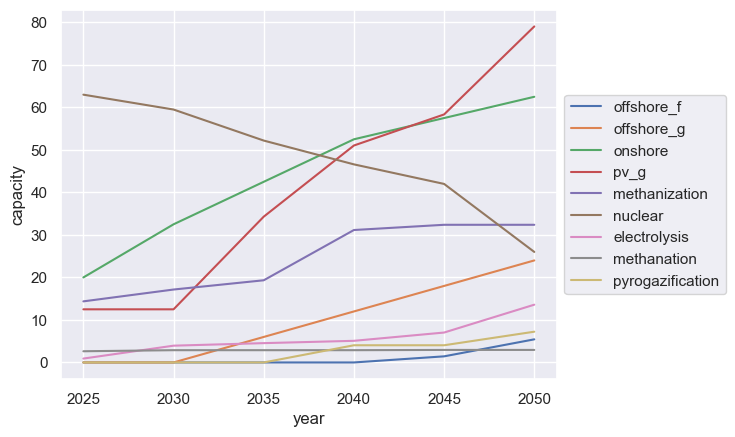

In [5]:
tmp = capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

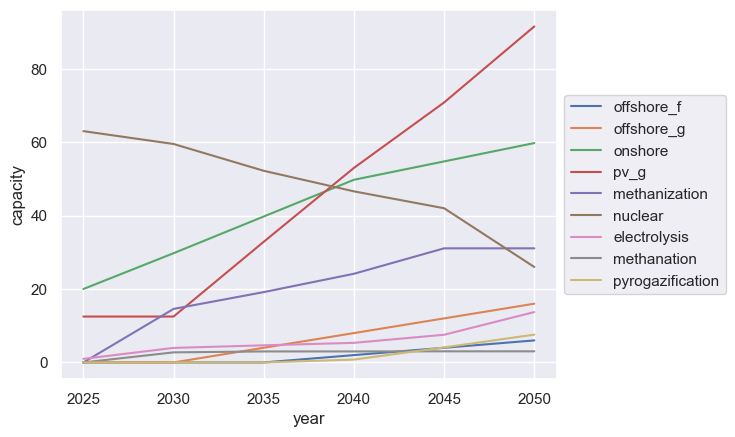

In [37]:
tmp = capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

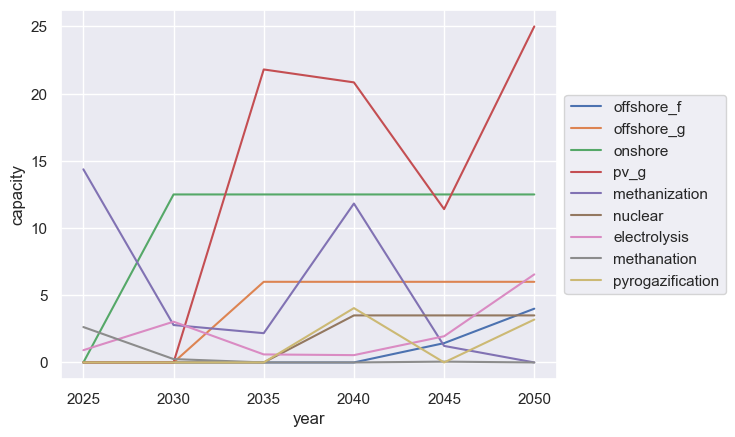

In [6]:
tmp = new_capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

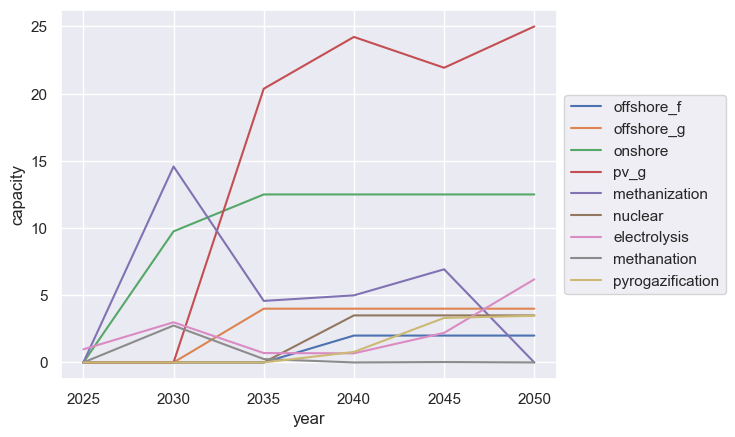

In [36]:
tmp = new_capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

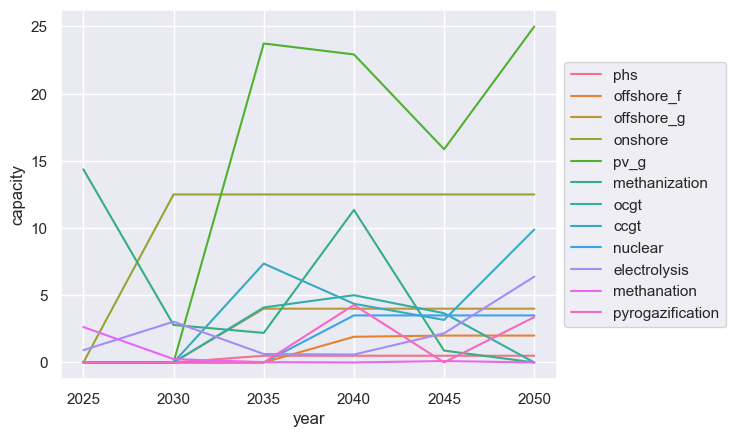

In [19]:
tmp = new_capacity_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'technology', 0: 'capacity'})
tmp = tmp.loc[tmp.technology.isin(["phs", "offshore_f", "offshore_g", "onshore", "pv_g", "methanization", "ocgt", "ccgt", "nuclear", "electrolysis", "methanation", "pyrogazification"])]
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="capacity", hue="technology")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

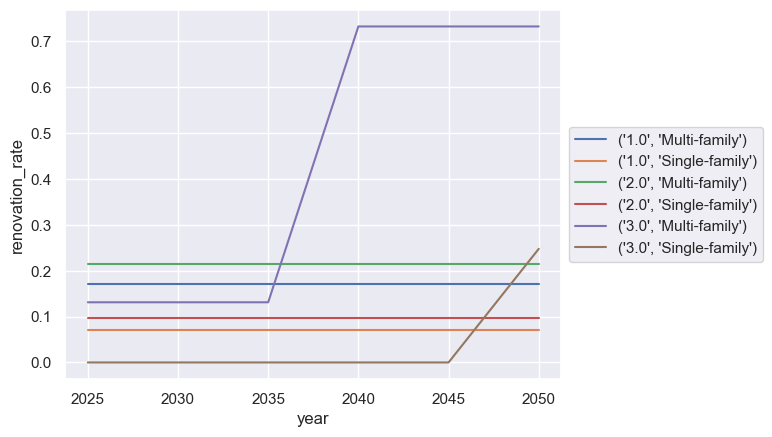

In [7]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

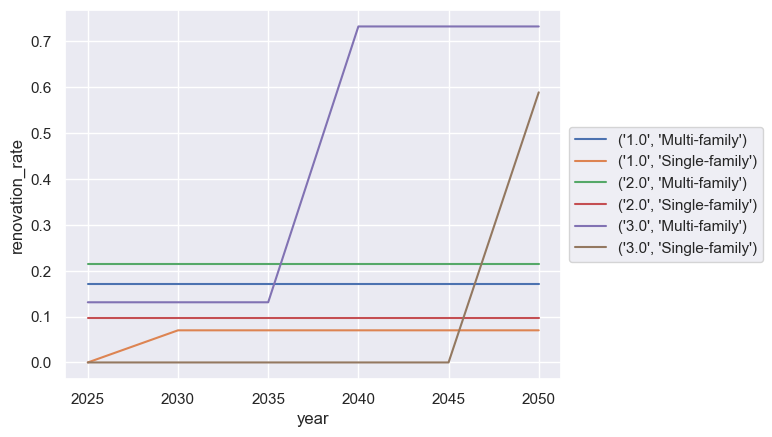

In [30]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

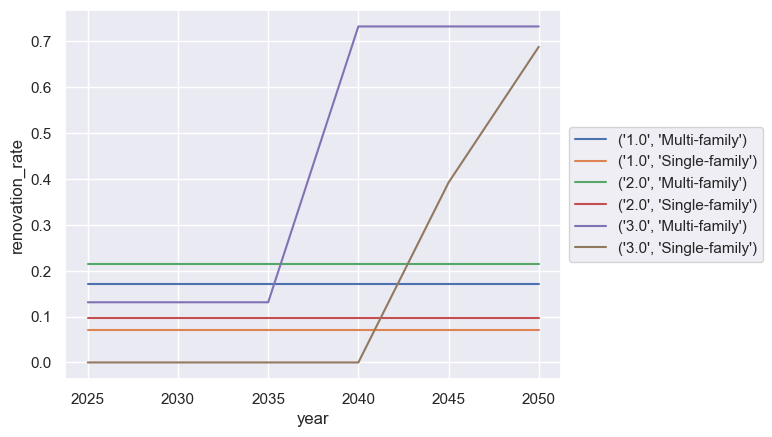

In [27]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

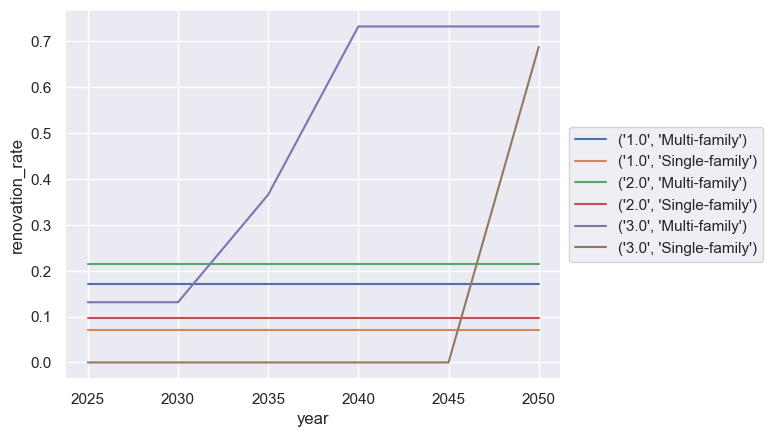

In [20]:
tmp = renovation_rate_df.transpose().stack().reset_index().rename(columns={'level_0': 'year', 'level_1': 'archetype', 0: 'renovation_rate'})
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(tmp, x="year", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Production

<Figure size 640x480 with 0 Axes>

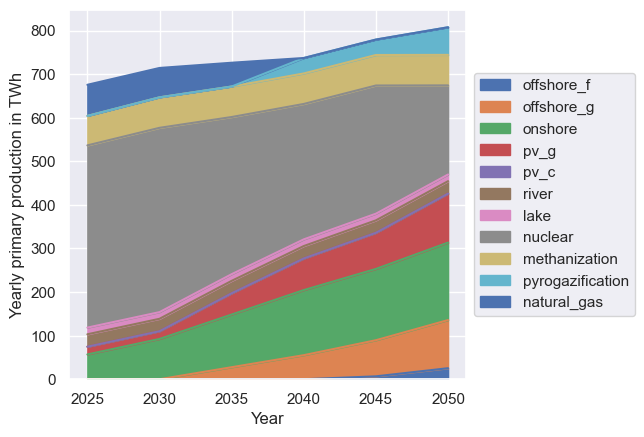

In [8]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

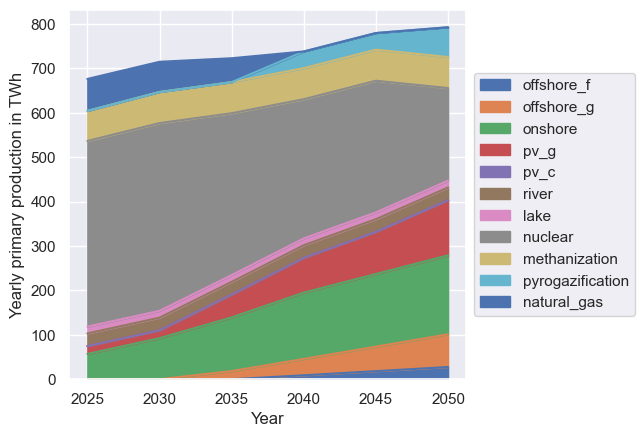

In [21]:
fig = plt.figure()
ax = primary_generation_df.T.plot.area()
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Heat production

<Figure size 640x480 with 0 Axes>

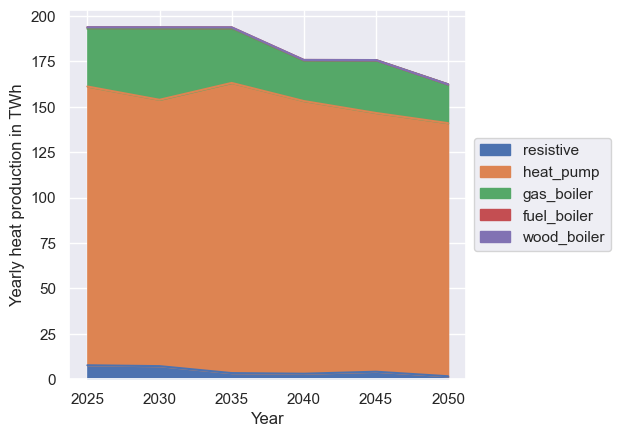

In [10]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 640x480 with 0 Axes>

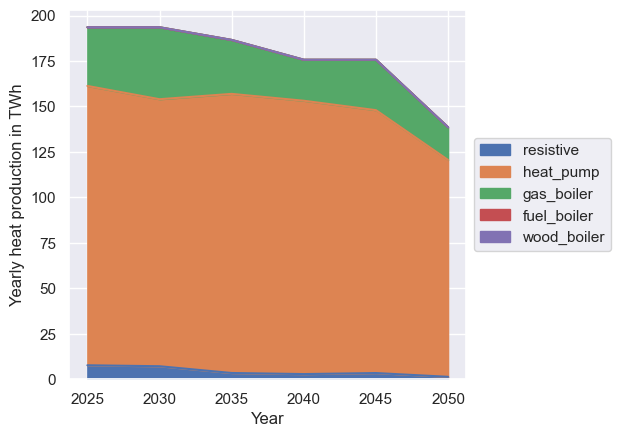

In [22]:
fig = plt.figure()
ax = heat_generation_df.T.plot.area()
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Year")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [35]:
generation_df

,2025,2030,2035,2040,2045,2050
river,28.482600,28.482600,28.482600,28.482600,28.482600,28.482600
lake,15.302186,15.302186,15.302186,15.302186,15.302186,15.302186
phs,2.694056,3.604021,4.758190,7.578768,12.159922,14.898726
offshore_f,0.000000,0.000000,0.000000,8.902561,18.224535,27.546509
offshore_g,0.000000,0.000000,18.410586,36.821173,55.231759,73.642345
onshore,56.889089,92.444770,120.889314,149.333858,163.556131,177.778403
onshore_V110,NaN,NaN,NaN,NaN,NaN,NaN
pv_g,17.774951,17.774951,51.494140,78.281685,95.010694,124.446012
pv_g_ns,NaN,NaN,NaN,NaN,NaN,NaN
pv_c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
renovation_rates_df

,2025,2030,2035,2040,2045,2050
"(1.0, Multi-family)",0.169990,0.169990,0.169990,0.169990,0.169990,0.169990
"(1.0, Single-family)",0.070004,0.070004,0.070004,0.070004,0.070004,0.070004
"(2.0, Multi-family)",0.215392,0.215392,0.215392,0.215392,0.215392,0.215392
"(2.0, Single-family)",0.097347,0.097347,0.097347,0.097347,0.097347,0.097347
"(3.0, Multi-family)",0.131056,0.131056,0.372039,0.732042,0.732042,0.732042
"(3.0, Single-family)",0.000000,0.000000,0.000000,0.000000,0.000000,0.687661


In [25]:
renovation_rates_df

,2025,2030,2035,2040,2045,2050
"(1.0, Multi-family)",0.169990,0.169990,0.169990,0.169990,0.169990,0.169990
"(1.0, Single-family)",0.070004,0.070004,0.070004,0.070004,0.070004,0.070004
"(2.0, Multi-family)",0.215392,0.215392,0.215392,0.215392,0.215392,0.215392
"(2.0, Single-family)",0.097347,0.097347,0.097347,0.097347,0.097347,0.097347
"(3.0, Multi-family)",0.131056,0.131056,0.131056,0.732042,0.732042,0.732042
"(3.0, Single-family)",0.000000,0.000000,0.000000,0.000000,0.051853,0.687661
